# Notice 

본 연구에서 사용된 데이터는 아래의 대회를 기반합니다. 

스마트 공장 제품 품질 상태 분류 AI 오프라인 해커톤  
[https://dacon.io/competitions/official/236080/overview/description]

해당 코드는 아래의 GitHub에서도 확인할 수 있습니다.  
[https://github.com/LGAimers/AI-PTA]


# 0. Libraries

!pip install plotly

In [1]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import missingno as msno
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

import warnings
warnings.filterwarnings(action='ignore')

SEED = 42
np.random.seed(SEED)

# 1. Dataset 

1,132 rows × 3,330 columns

- **Categorical variable (2)**
    - LINE: 제품이 들어간 공정 LINE 종류 (6)
        - 'T100306', 'T100304', T050304', 'T010306', 'T010305', 'T050307'
        - 434, 404, 86, 76, 66, 66
    - PRODUCT_CODE: 제품의 CODE 번호 (3) 
        - 'T_31', 'A_31', 'O_31'
        - 830, 294, 8
- **Numerical variable (3326)**
    - X(1~3326): 공정 과정에서 추출되어 비식별화된 변수
- **Y variable (1)**
    - Y_Quality: 제품 품질 관련 정량적 수치 
    - Y_Class: 제품 품질 상태 
        - 0: 적정 기준 미달 (부적합) 1: 적정 2: 적정 기준 초과 (부적합) (0과 2를 Abnormal, 1을 Abnormal로 변형)
        - 1:766 
        - 0:165, 2:201 (total 366)

In [2]:
path = "./Dataset/"

# original data -> original
original = pd.read_csv(path+"train.csv")  
original = original.drop(['PRODUCT_ID'], axis=1)        # PRODUCT_ID: 제품 고유의 ID
original['Y_Class'] = original['Y_Class'].astype('str') # For plotting easily

dataT = original[original['PRODUCT_CODE'] =='T_31']
dataO = original[original['PRODUCT_CODE'] =='O_31']
dataA = original[original['PRODUCT_CODE'] =='A_31']
dataTO = pd.concat([dataT, dataO])

print("Original data: ", original.shape)
print("T data: ", dataT.shape)
print("O data: ", dataO.shape)
print("A data: ", dataA.shape)

original

Original data:  (1132, 3330)
T data:  (830, 3330)
O data:  (8, 3330)
A data:  (294, 3330)


,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.528141,T100306,T_31,2.0,87.0,0.0,45.0,10.0,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,0,0.516681,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1128,1,0.530413,T100304,T_31,2.0,102.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1129,1,0.533311,T100306,T_31,1.0,88.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1130,0,0.513135,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. EDA with Plotting

- Y Class와 Y Quality 분포 및 경향성 파악 
- 범주형 변수별 데이터 개수 확인
- LINE-PRODUCT CODE 군집 데이터별 개수 확인
- LINE-PRODUCT CODE 군집 데이터별 Y Class 분포 확인

In [3]:
nonX_original = original.iloc[:,  :4].drop(['Y_Quality'], axis=1).copy()
X_original = original.iloc[:, 4:].copy()

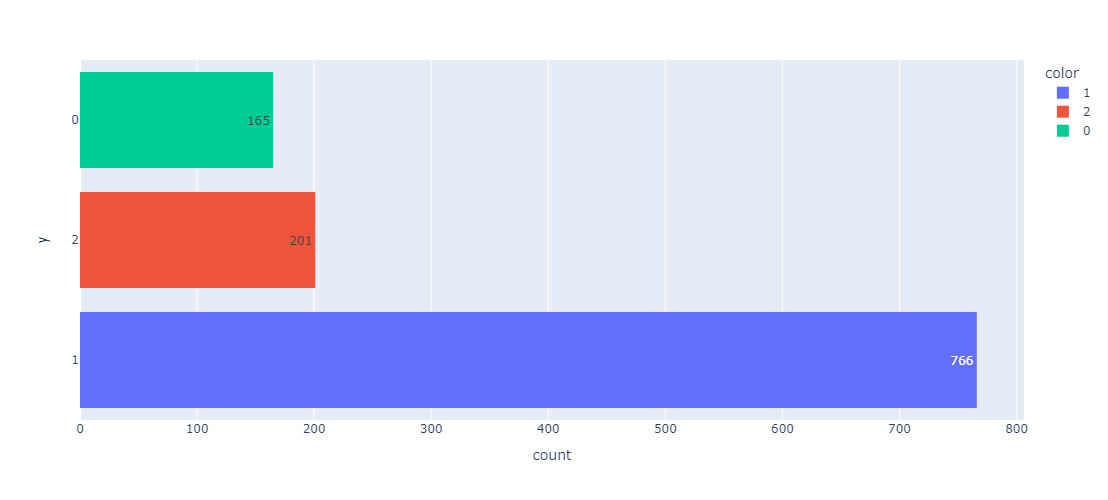

In [41]:
fig = px.histogram(y=original.Y_Class, width=700, height=500, color=original.Y_Class, text_auto=True)
fig.show()

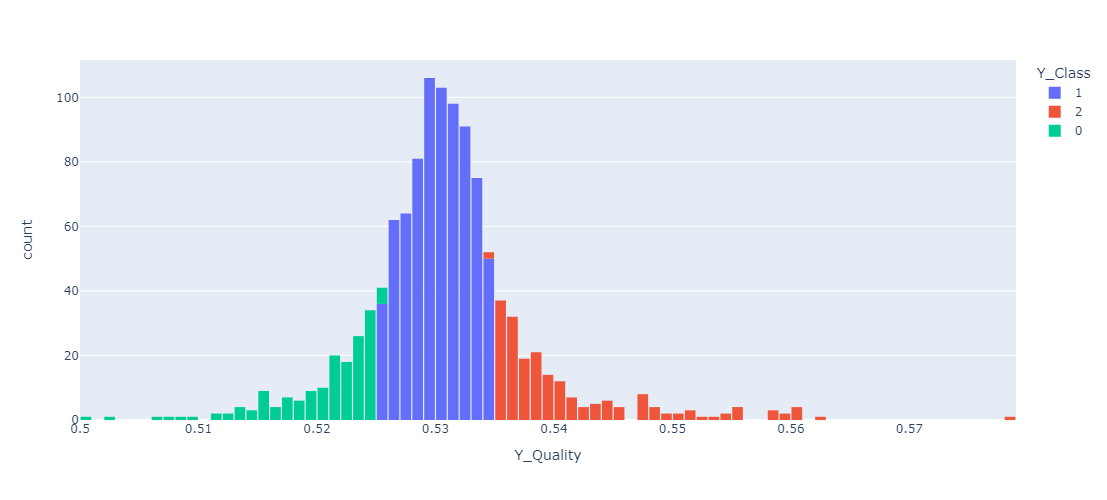

In [34]:
fig = px.histogram(original, x="Y_Quality", color="Y_Class", width=700, height=500, nbins=100)
fig.update_layout(bargap=0.1)
fig.show()

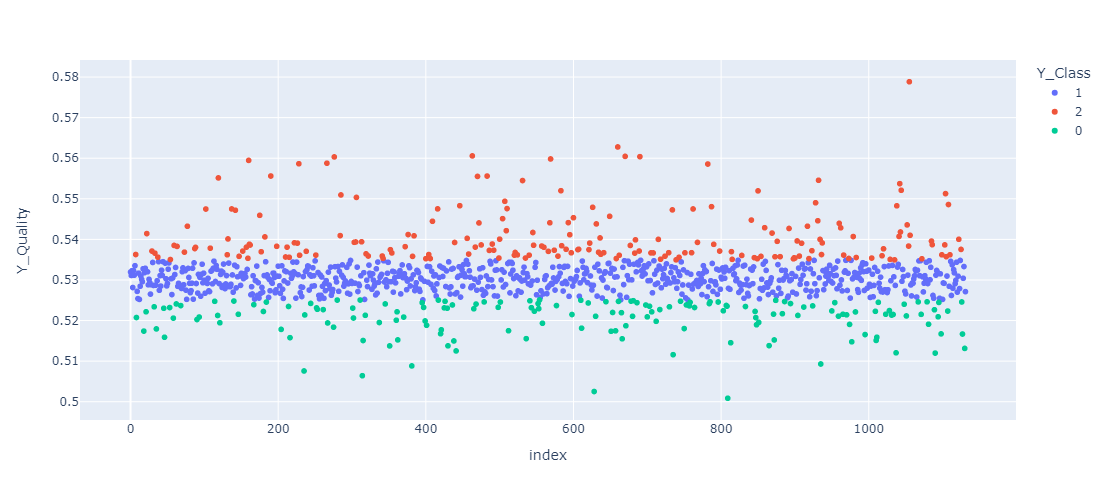

In [38]:
fig = px.scatter(original, x=original.index, y=original.Y_Quality, color=original.Y_Class, width=700, height=500,)
fig.show()

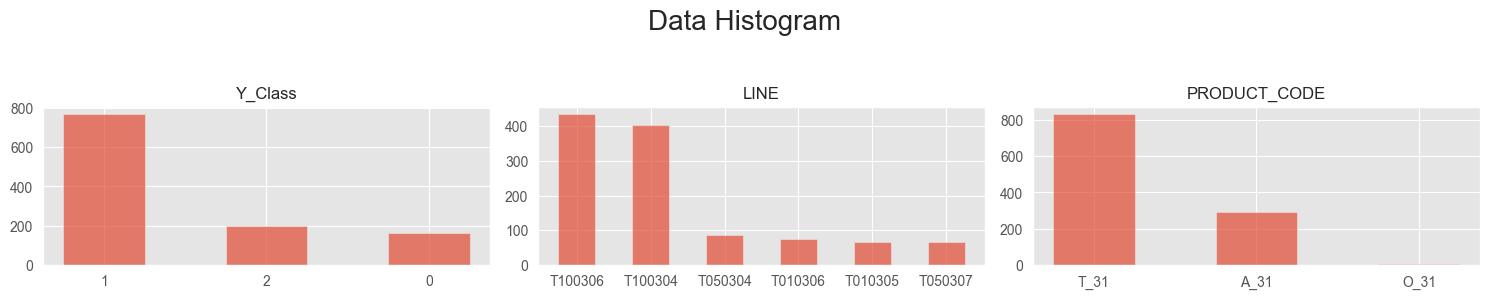

In [41]:
plt.style.use("ggplot")

# 히스토그램을 사용해서 데이터의 분포 확인
plt.figure(figsize=(15,7))
plt.suptitle("Data Histogram", fontsize=20)

# 시각화할 범주형 변수들 설정
cols = ['Y_Class', 'LINE', 'PRODUCT_CODE']
for i in range(len(cols)):
    plt.subplot(3,3,i+1)
    plt.title(cols[i], fontsize=12)
    if len(nonX_original[cols[i]].unique()) > 20:
        plt.hist(nonX_original[cols[i]], color='b', alpha=0.7)
    else:
        temp = nonX_original[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

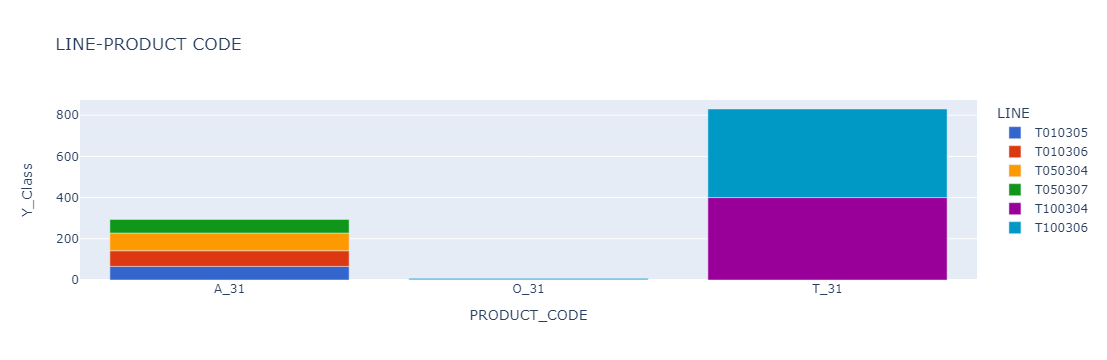

In [7]:
# LINE-PRODUCT 군집 데이터별 개수 확인
grouped = nonX_original['Y_Class'].groupby([nonX_original['PRODUCT_CODE'], nonX_original['LINE']]).count()
grouped = grouped.to_frame().reset_index()
fig = px.bar(grouped, x="PRODUCT_CODE", y="Y_Class", color = "LINE", title="LINE-PRODUCT CODE", color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

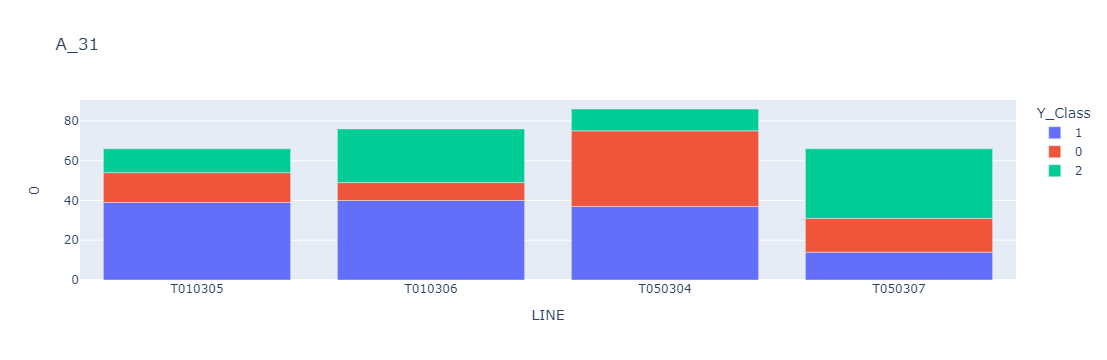

In [20]:
# A Product는 독립적인 4개의 LINE 사용 
# 비정상 데이터와 정상 데이터의 개수가 비슷하거나 정상 데이터가 더 많음
grouped = nonX_original.groupby([nonX_original['PRODUCT_CODE'], nonX_original['LINE']]).value_counts().reset_index()
A_group = grouped[grouped['PRODUCT_CODE']=='A_31']
fig = px.bar(A_group, x="LINE", y=0, color ="Y_Class", title="A_31")
fig.show()

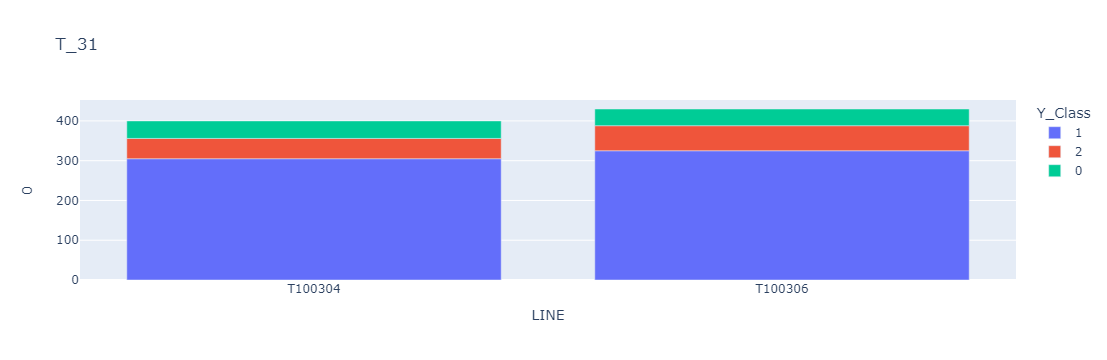

In [18]:
# O Product는 T Product와 동일하게 2개의 LINE만 사용 
# T Product는 A Product 대비 비정상 데이터가 더 적은 불균형성을 보임
grouped = nonX_original.groupby([nonX_original['PRODUCT_CODE'], nonX_original['LINE']]).value_counts().reset_index()
A_group = grouped[grouped['PRODUCT_CODE']=='T_31']
fig = px.bar(A_group, x="LINE", y=0, color ="Y_Class", title="T_31")
fig.show()

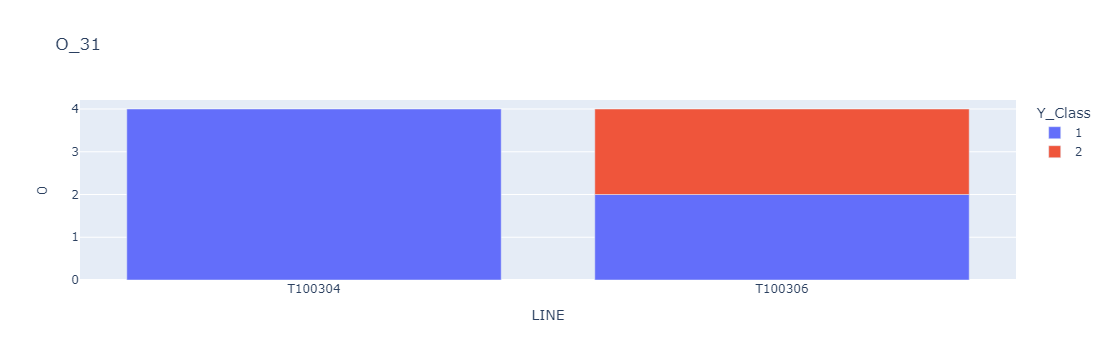

In [19]:
# O Product는 T Product와 동일하게 2개의 LINE만 사용 
grouped = nonX_original.groupby([nonX_original['PRODUCT_CODE'], nonX_original['LINE']]).value_counts().reset_index()
A_group = grouped[grouped['PRODUCT_CODE']=='O_31']
fig = px.bar(A_group, x="LINE", y=0, color ="Y_Class", title="O_31")
fig.show()

<AxesSubplot: >

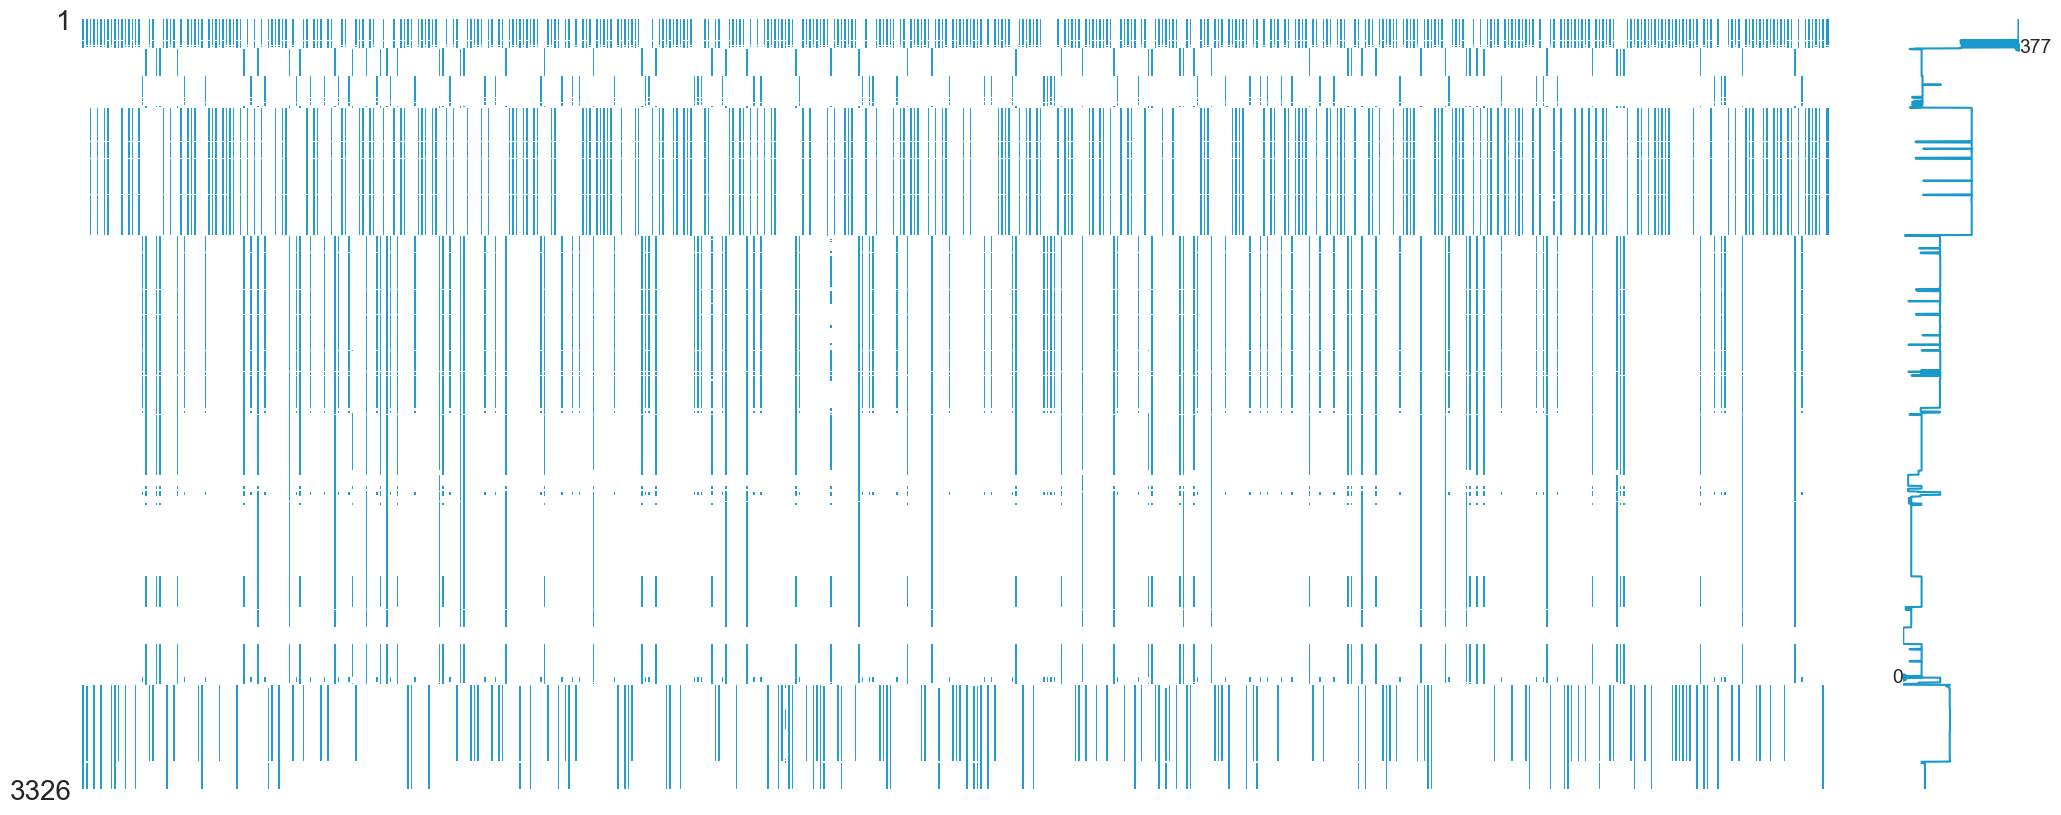

In [48]:
# 결측치의 개수가 너무 많은 관계로 500개 단위로 끊어서 X변수들의 결측치를 확인해야 함
msno.matrix(X_original.T.iloc[:,:500], color=(0.1, 0.6, 0.8))

# 3. Data Analysis based on LINE and PRODUCT_CODE

## 3.1. PRODUCT_CODE: T & O

**T-31 & O-31**

T100306 & T100304  
(430, 400 / 4, 4)


In [61]:
T304 = dataT[dataT['LINE']=='T100304'].reset_index(drop=True)
T306 = dataT[dataT['LINE']=='T100306'].reset_index(drop=True)
X_T304 = T304.iloc[:,4:]
X_T306 = T306.iloc[:,4:]

O304 = dataO[dataO['LINE']=='T100304'].reset_index(drop=True)
O306 = dataO[dataO['LINE']=='T100306'].reset_index(drop=True)
X_O304 = O304.iloc[:,4:]
X_O306 = O306.iloc[:,4:]

X_dataTO = dataTO.iloc[:, 4:].copy()
nonX_dataTO = dataTO.iloc[:, :4].copy()

### LINE별 결측치 양상 

LINE별 결측치 양상이 동일함 
- T와 O데이터는 concat한 상태로 사용해도 될 것으로 예상
- 결측치 그래프에서 중간에 큰 결측치 공간 발견 -> T & O Product 공정에 쓰이지 않는 다량의 X변수가 존재함을 확인

<AxesSubplot: >

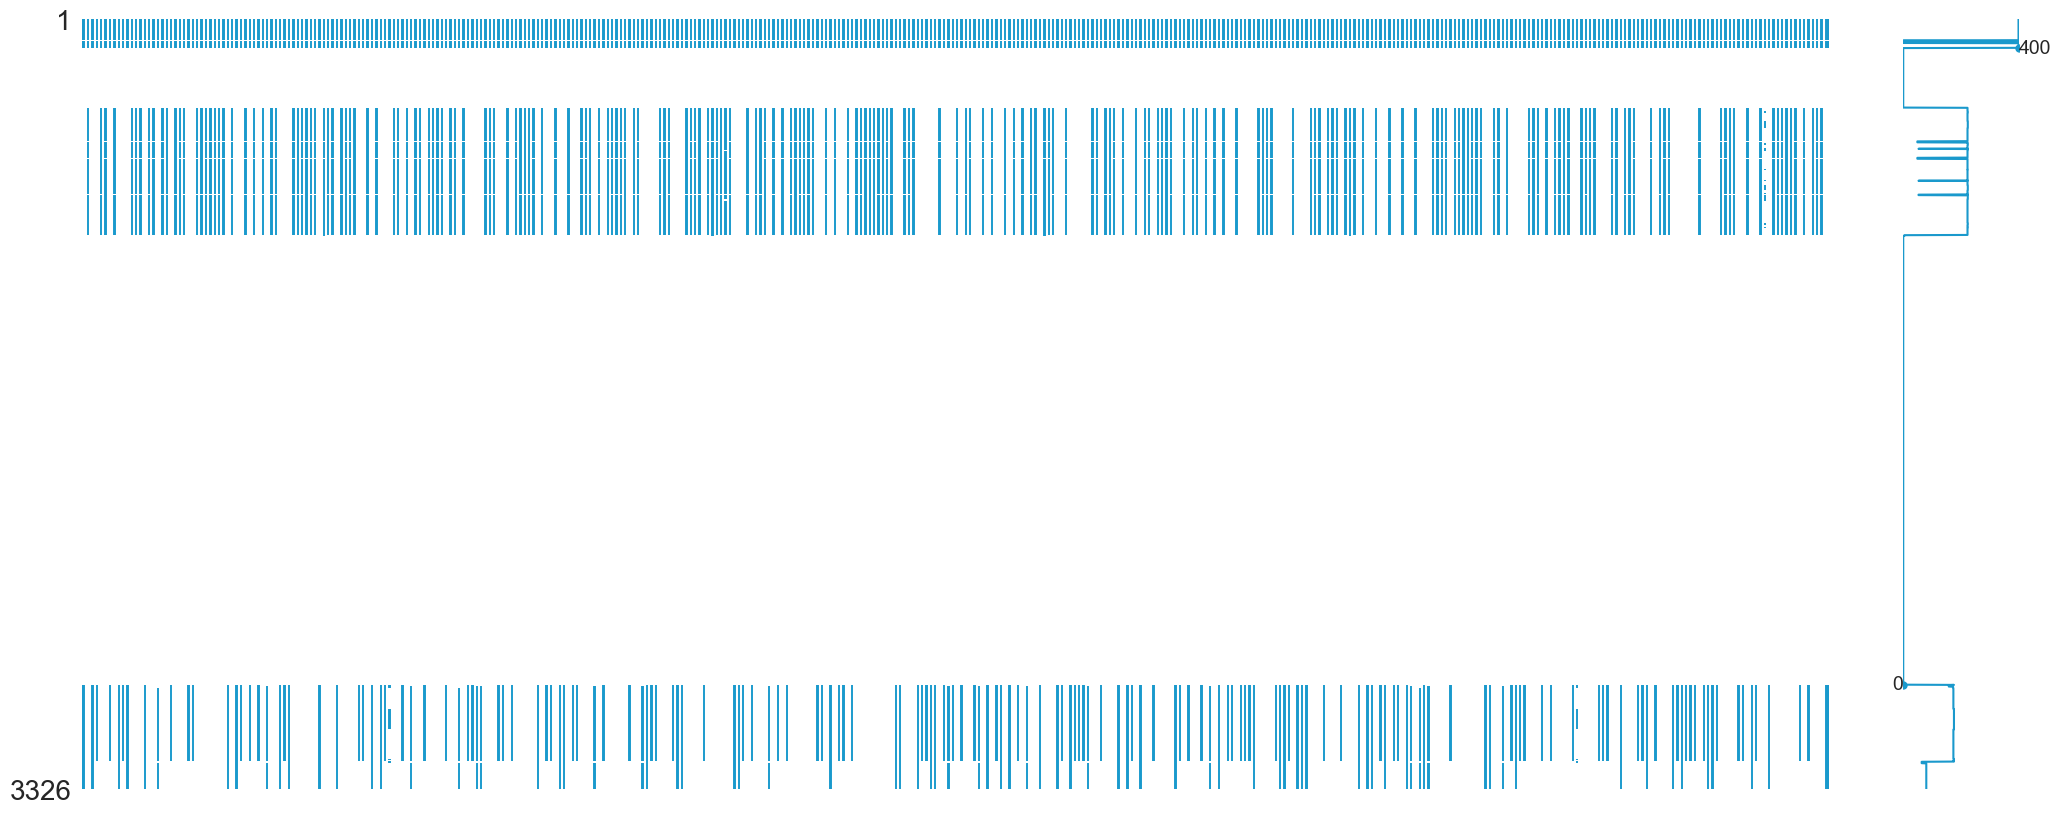

In [55]:
msno.matrix(X_T304.T, color=(0.1, 0.6, 0.8))

<AxesSubplot: >

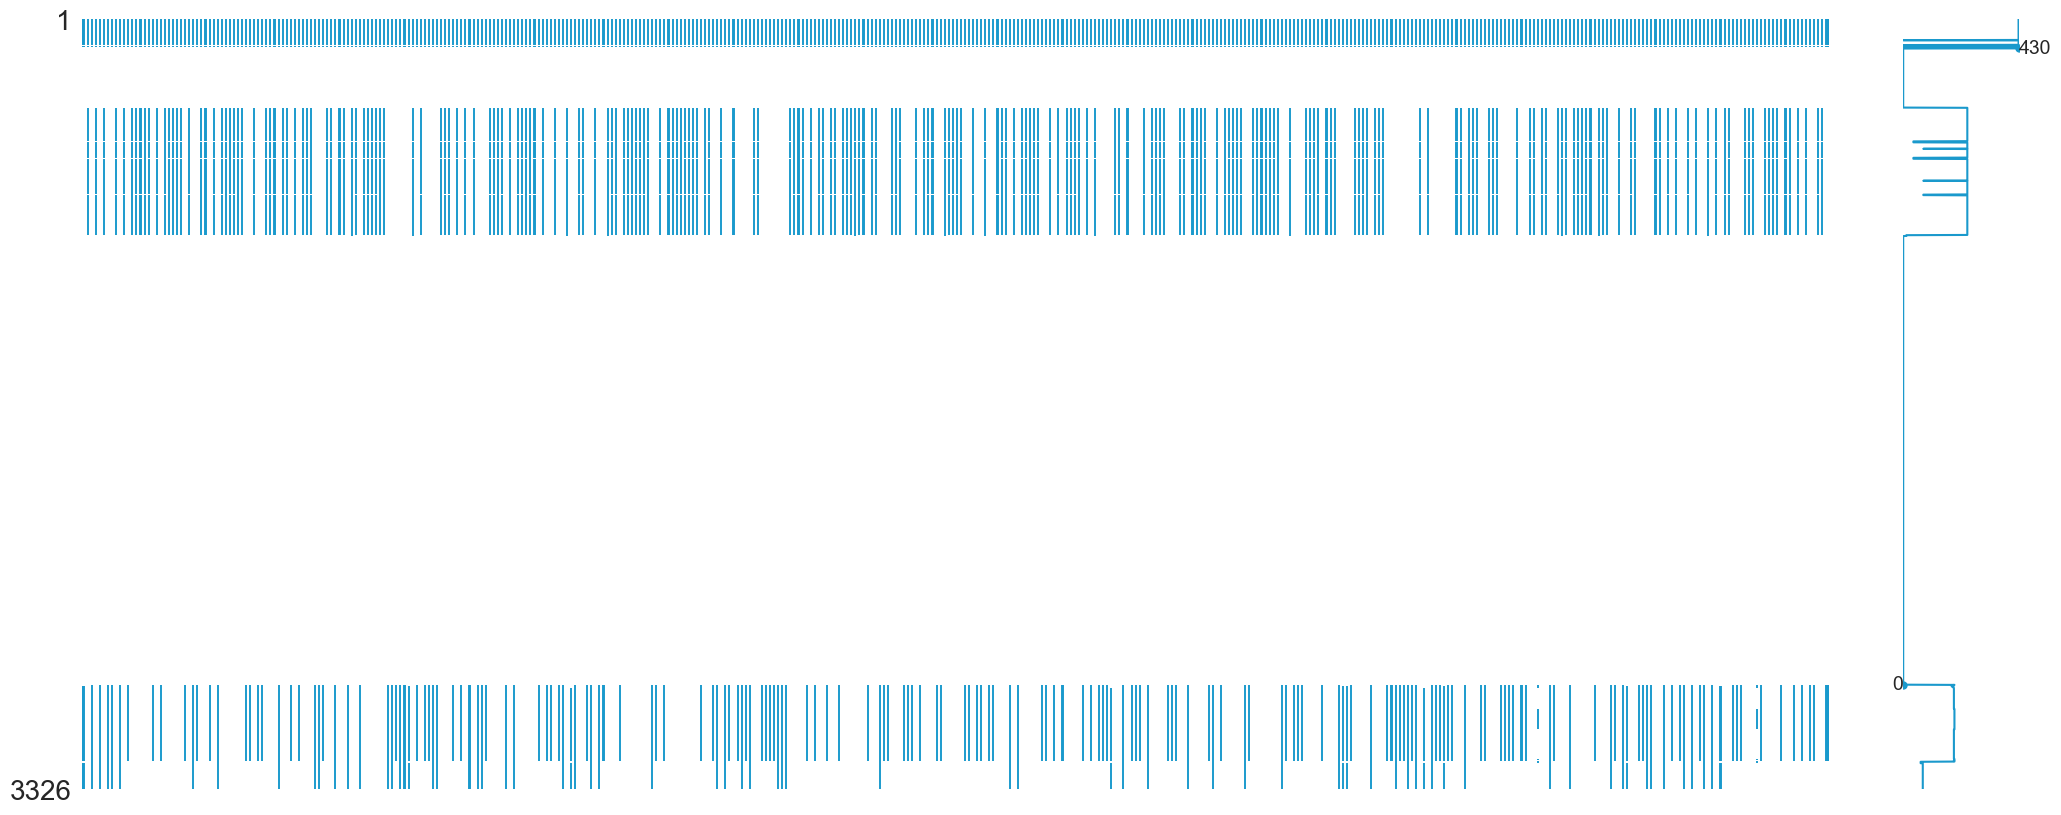

In [56]:
msno.matrix(X_T306.T, color=(0.1, 0.6, 0.8))

<AxesSubplot: >

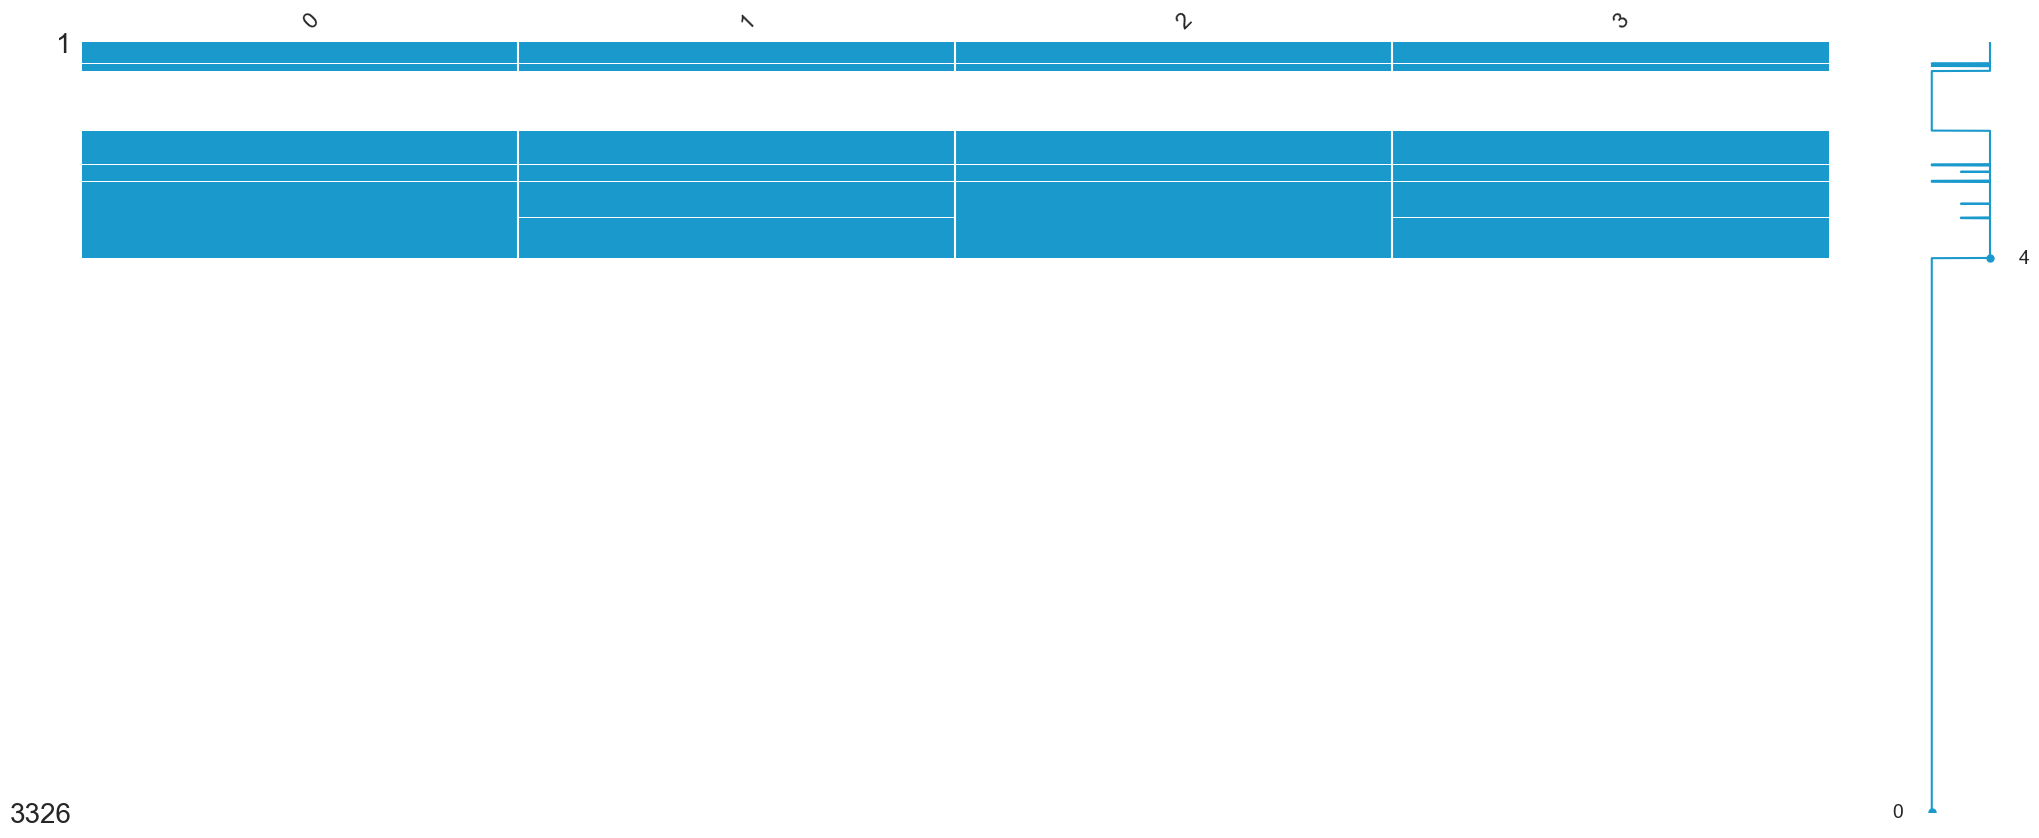

In [58]:
msno.matrix(X_O304.T, color=(0.1, 0.6, 0.8))

<AxesSubplot: >

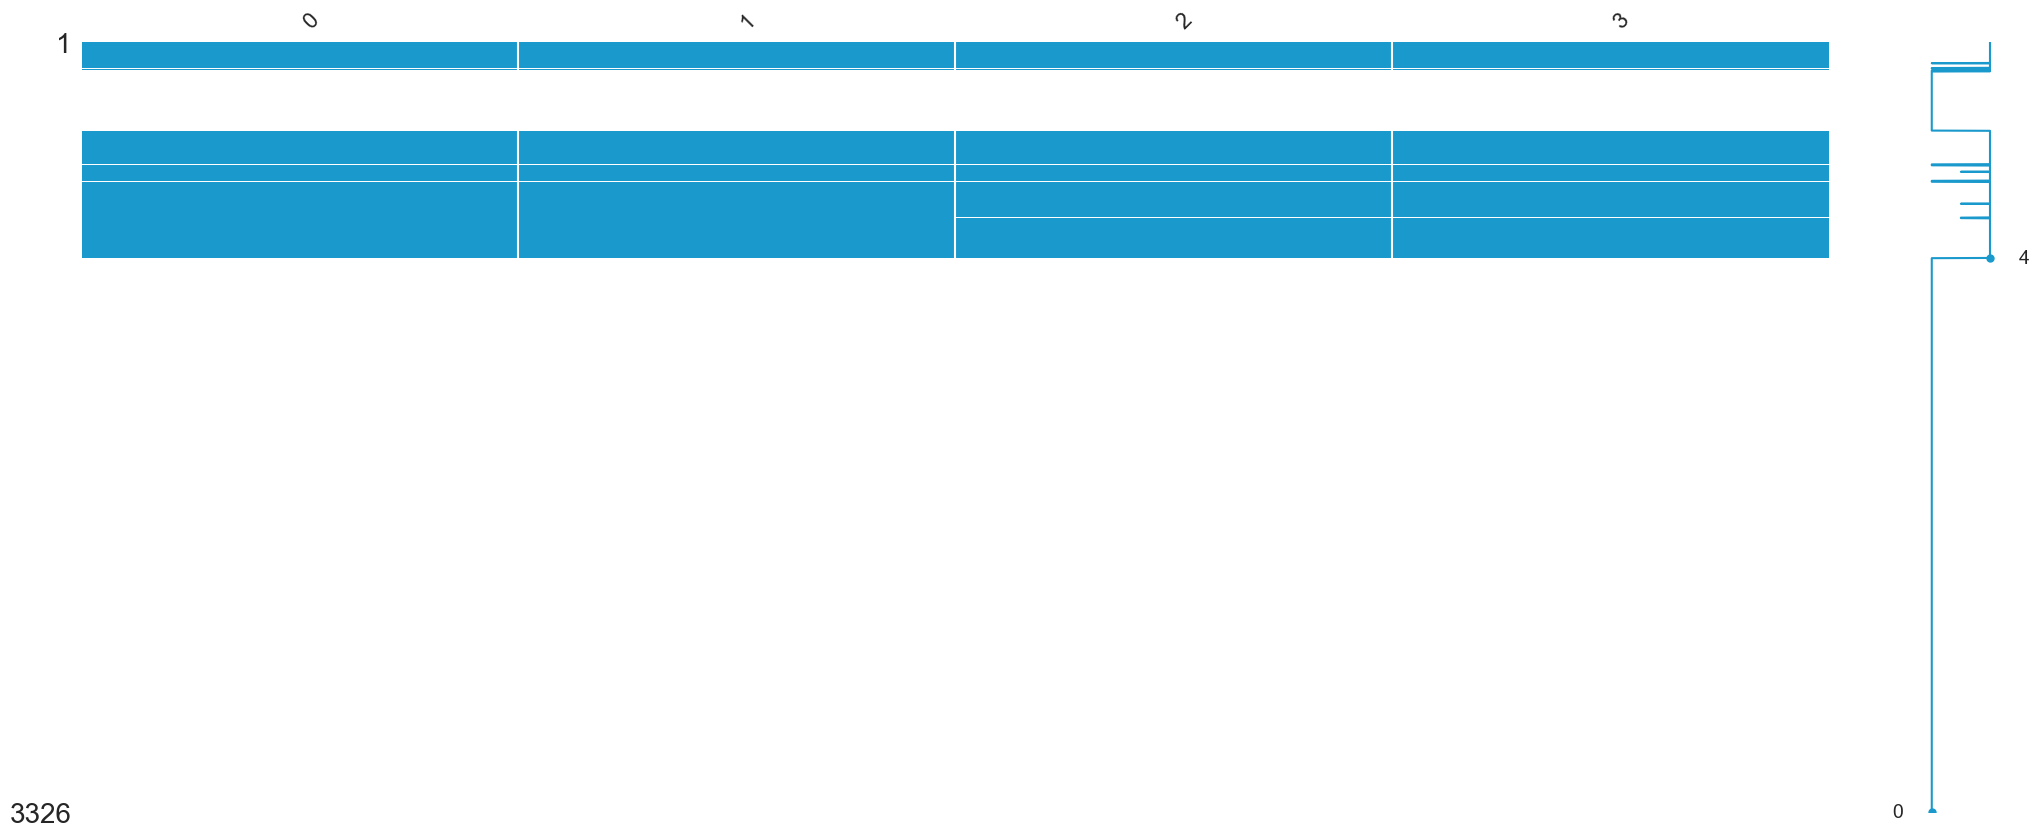

In [59]:
msno.matrix(X_O306.T, color=(0.1, 0.6, 0.8))

<AxesSubplot: >

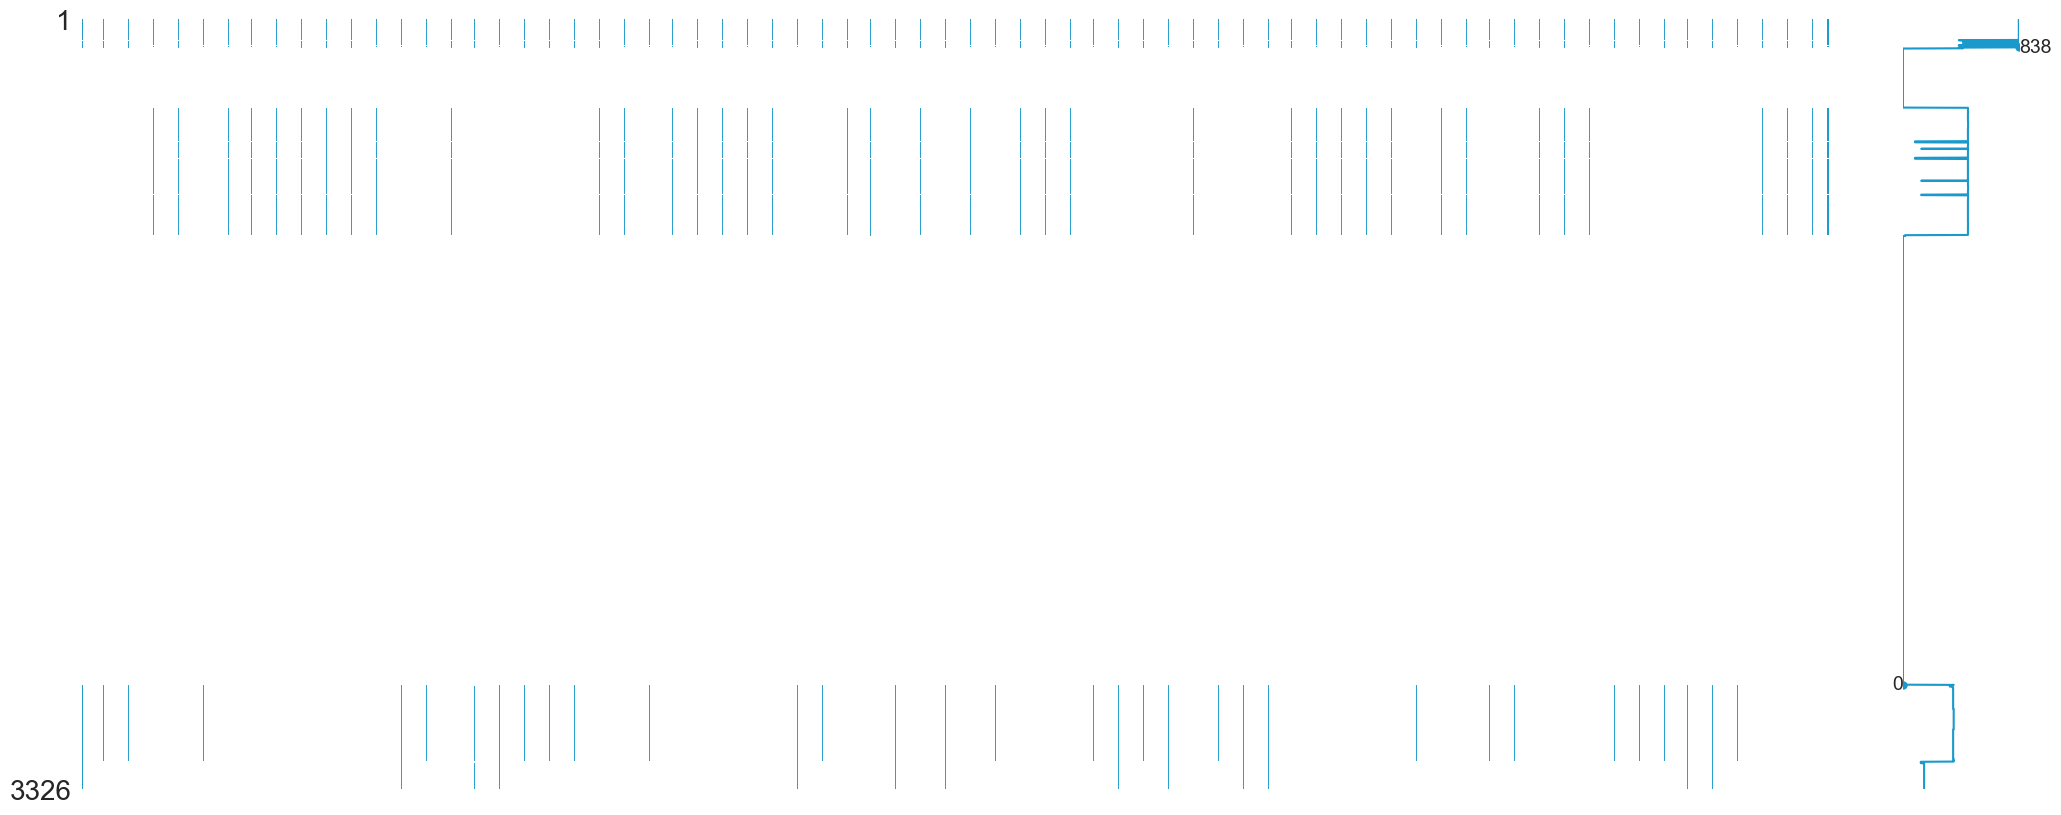

In [63]:
# 중간에 큰 결측치가 보임
# 즉, 쓰이지 않는 X변수가 다량으로 존재한다는 것을 알 수 있음 
msno.matrix(X_dataTO.T, color=(0.1, 0.6, 0.8))

### 결측치 제거

총 2,648개의 유효하지 않은 X변수가 제거됨

0. 원본 데이터 (838, 3330)
1. 같은 값으로만 채워진 column 제거 (838, 1030)
2. 모든 행이 같은 값을 가지는 중복된 column 제거 (838, 682)

In [71]:
# 1. Handling missing values 
processed_TO = dataTO.copy().fillna(0)
print("0) 원본 데이터 -> ", processed_TO.shape)

# 2. 같은 값으로만 채워진 column 삭제 
value_counts = processed_TO.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))
unique_columns = value_counts[value_counts >= 2].index
duplicated_columns = value_counts[value_counts <= 1].index
processed_TO = processed_TO.drop(duplicated_columns, axis=1)
print("1) 같은 값으로만 채워진 변수 제거 -> ", processed_TO.shape)

# 3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
df = processed_TO.iloc[:,4:].T.drop_duplicates(keep='first').T
processed_TO = pd.concat([processed_TO.iloc[:,:4], df], axis=1)
print("2) 모든 행이 같은 값을 가지는 중복된 변수 제거 -> ", processed_TO.shape)

processed_TO

0) 원본 데이터 ->  (838, 3330)
1) 같은 값으로만 채워진 변수 제거 ->  (838, 1030)
2) 모든 행이 같은 값을 가지는 중복된 변수 제거 ->  (838, 682)


,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,45.0,10.0,45.0,10.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,45.0,10.0,53.0,10.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,45.0,10.0,60.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,0.528141,T100306,T_31,2.0,87.0,45.0,10.0,53.0,10.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,45.0,10.0,51.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1,0.529740,T100304,O_31,154.0,97.0,45.0,11.0,45.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
605,1,0.532343,T100306,O_31,146.0,94.0,45.0,10.0,67.0,11.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
736,1,0.530533,T100304,O_31,4.0,98.0,45.0,11.0,45.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
898,2,0.535205,T100306,O_31,6.0,89.0,45.0,10.0,51.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


### 데이터 시각화 


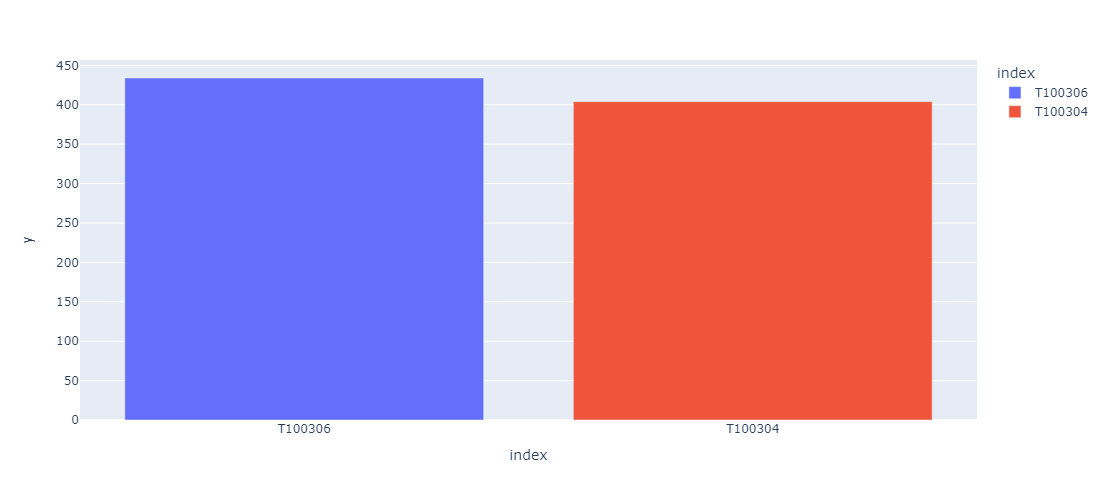

In [67]:
df = dataTO.LINE.value_counts()
fig = px.bar(df, x=df.index, y=df.values, color=df.index, width=700, height=500)
fig.show()

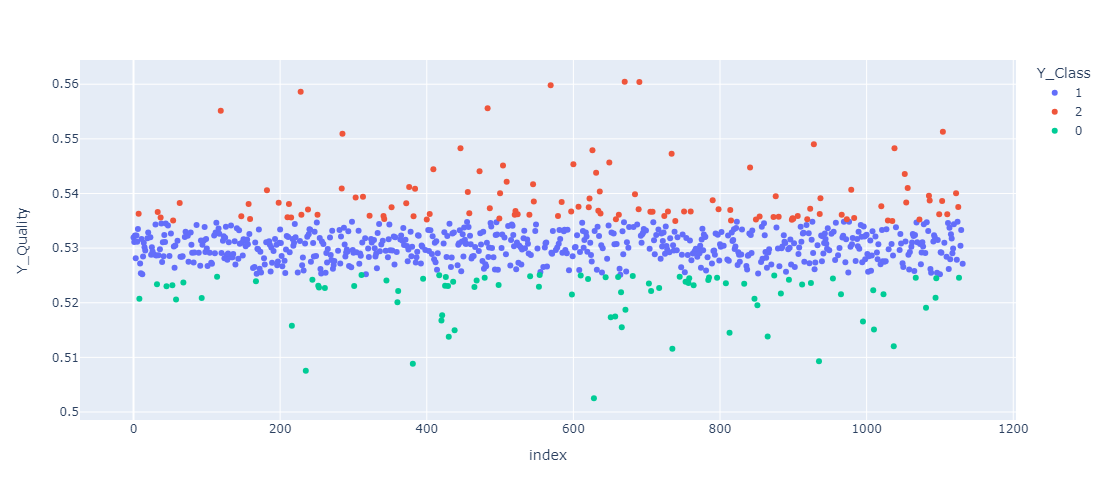

In [68]:
fig = px.scatter(dataTO, x=dataTO.index, y=dataTO.Y_Quality, color=dataTO.Y_Class, width=700, height=500)
fig.show()

## 3.2. PRODUCT_CODE: A

**A-31**

T050304 & T050307
(86 / 66)

T010305 & T010306
(76 / 66) 


In [72]:
# 각 라인별 데이터
A304 = dataA[dataA['LINE']=='T050304'].reset_index(drop=True)
A307 = dataA[dataA['LINE']=='T050307'].reset_index(drop=True)
X_A304 = A304.iloc[:,4:]
X_A307 = A307.iloc[:,4:]

A305 = dataA[dataA['LINE']=='T010305'].reset_index(drop=True)
A306 = dataA[dataA['LINE']=='T010306'].reset_index(drop=True)
X_A305 = A305.iloc[:,4:]
X_A306 = A306.iloc[:,4:]

# 두 종류의 라인 군집 데이터 
A503 = pd.concat([A304, A307]).reset_index(drop=True)
A103 = pd.concat([A305, A306]).reset_index(drop=True)
X_A503 = A503.iloc[:,4:]
X_A103 = A103.iloc[:,4:]

X_dataA = dataA.iloc[:, 4:].copy()
nonX_dataA = dataA.iloc[:, :4].copy()

### LINE별 결측치 양상

총 4개의 LINE이 두 개의 군집으로 비슷한 양상을 보임 
- T050304 & T050307
- T010305 & T010306 
- A데이터에 대해서는 LINE으로 나누어 2종류의 군집으로 데이터를 활용해야할 것으로 예상됨
- 결측치 그래프에서 중간에 큰 결측치 공간 발견 -> A 공정에 쓰이지 않는 다량의 X변수가 존재함을 확인
    - 특히, LINE별로 쓰이는 X변수가 다르기 때문에 이에 맞게 전처리를 진행해야 할 것으로 예상됨 

<AxesSubplot: >

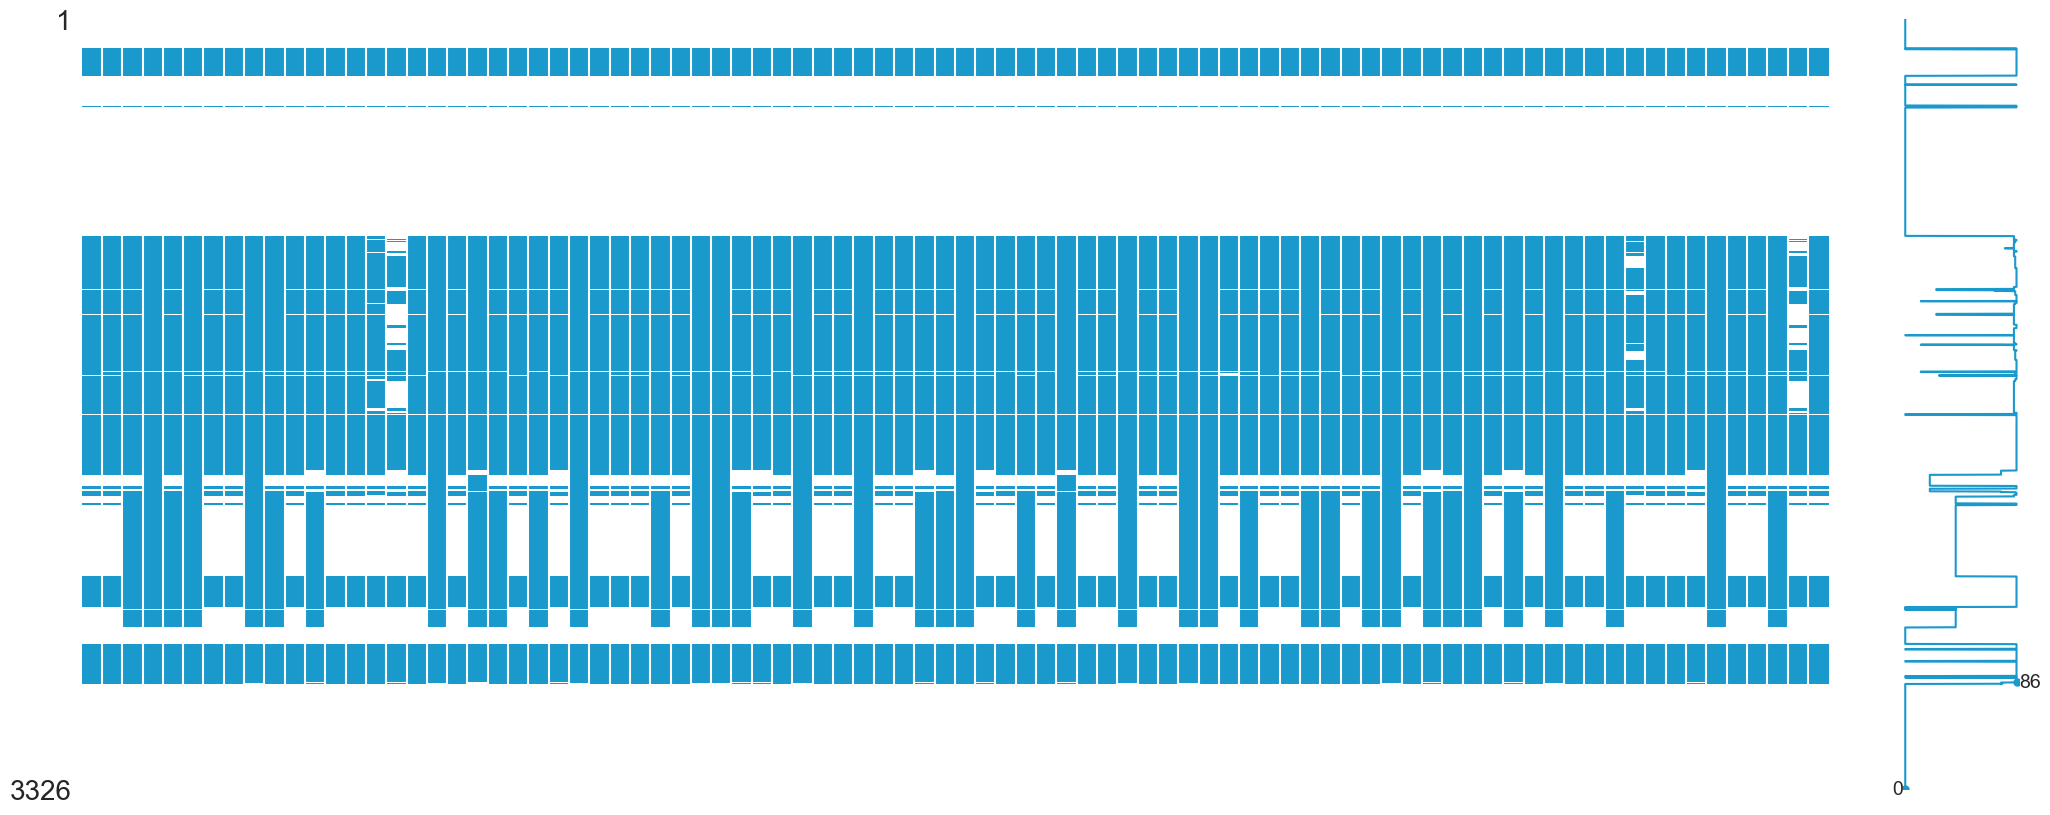

In [73]:
msno.matrix(X_A304.T, color=(0.1, 0.6, 0.8))

<AxesSubplot: >

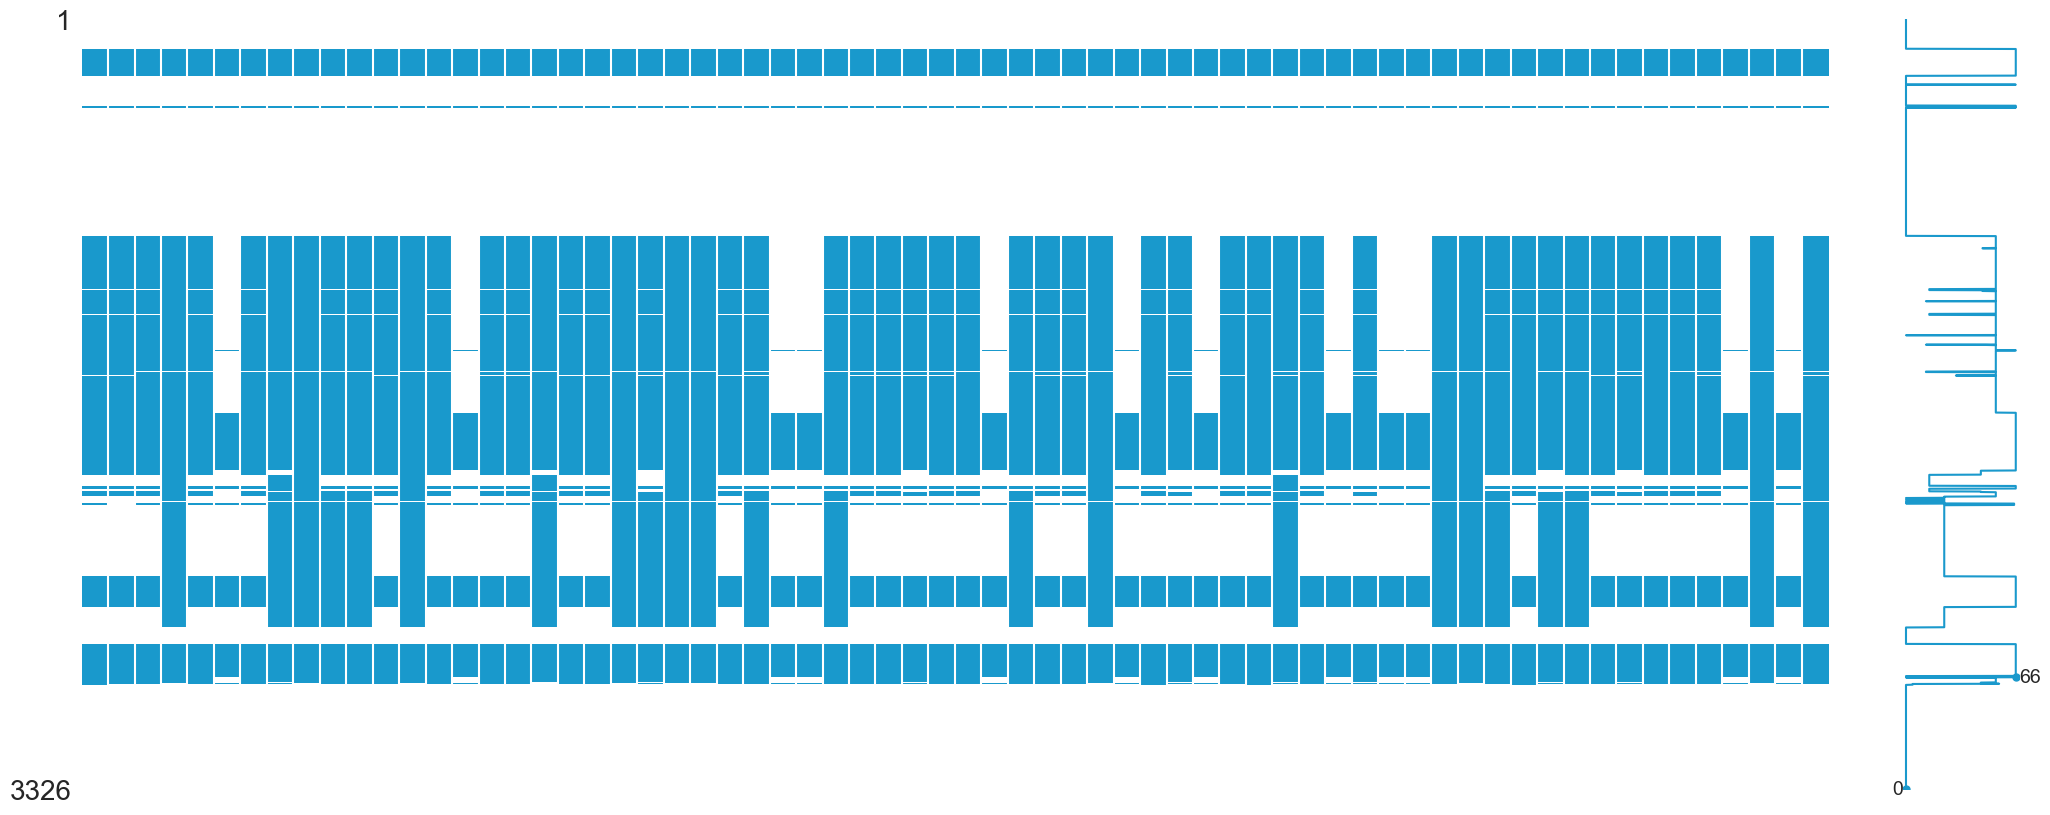

In [74]:
msno.matrix(X_A307.T, color=(0.1, 0.6, 0.8))

<AxesSubplot: >

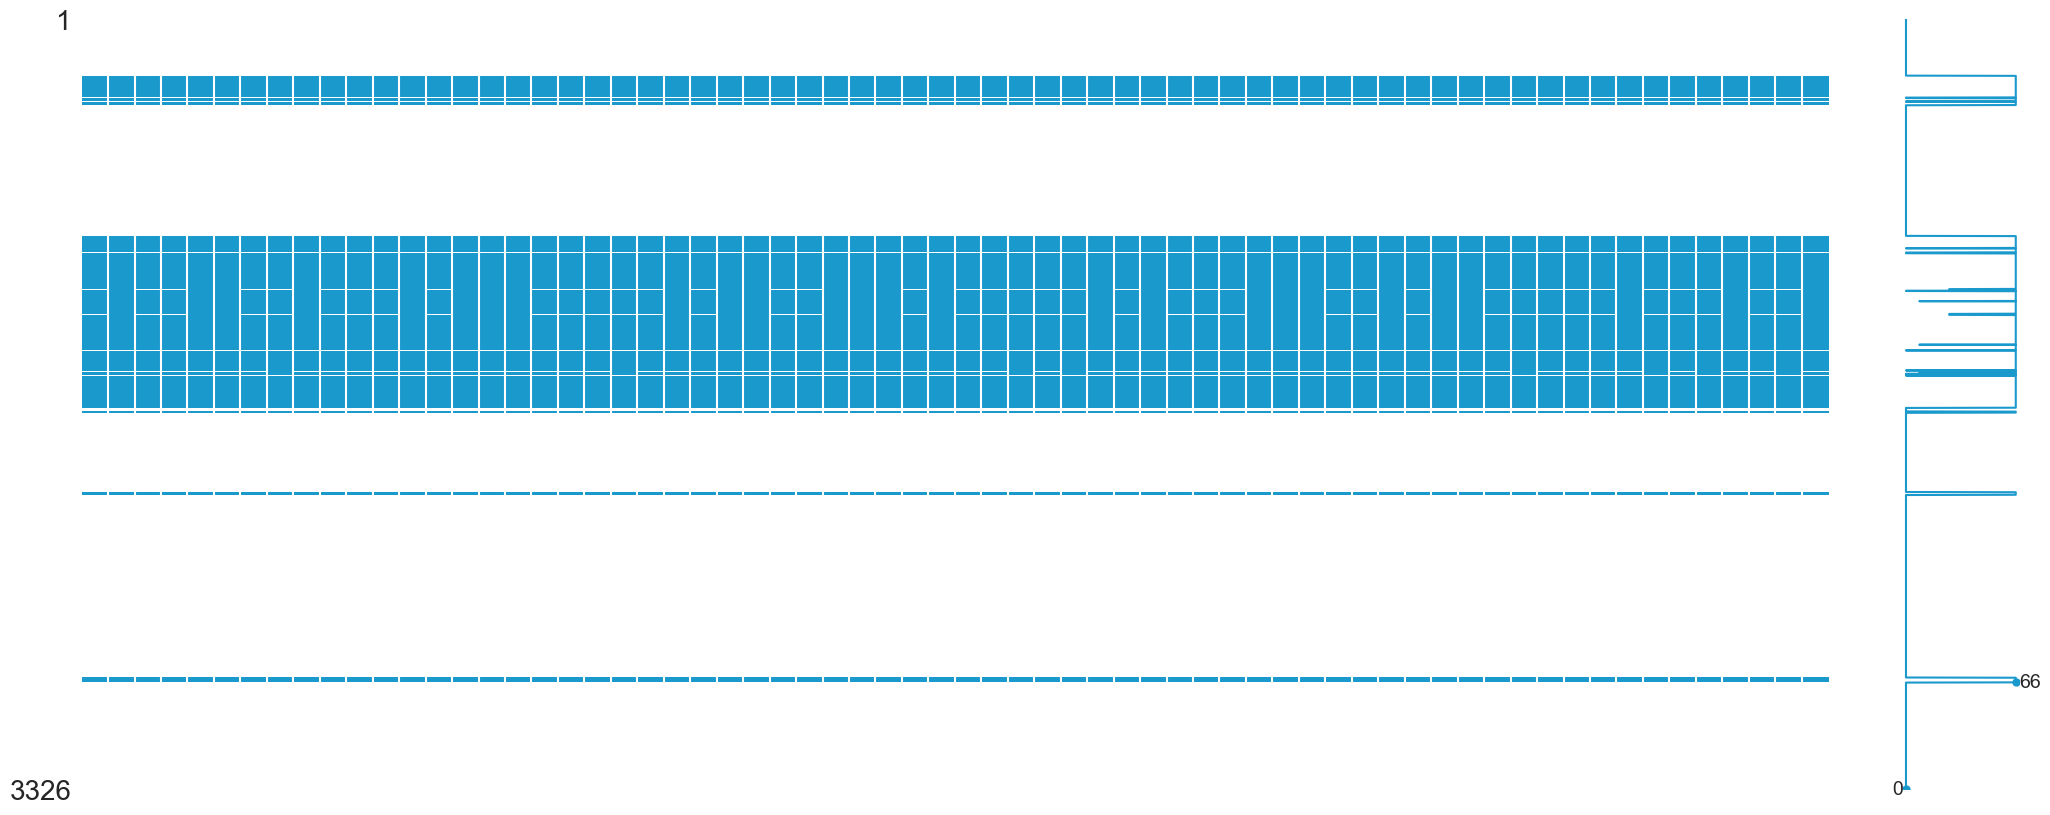

In [75]:
msno.matrix(X_A305.T, color=(0.1, 0.6, 0.8))

<AxesSubplot: >

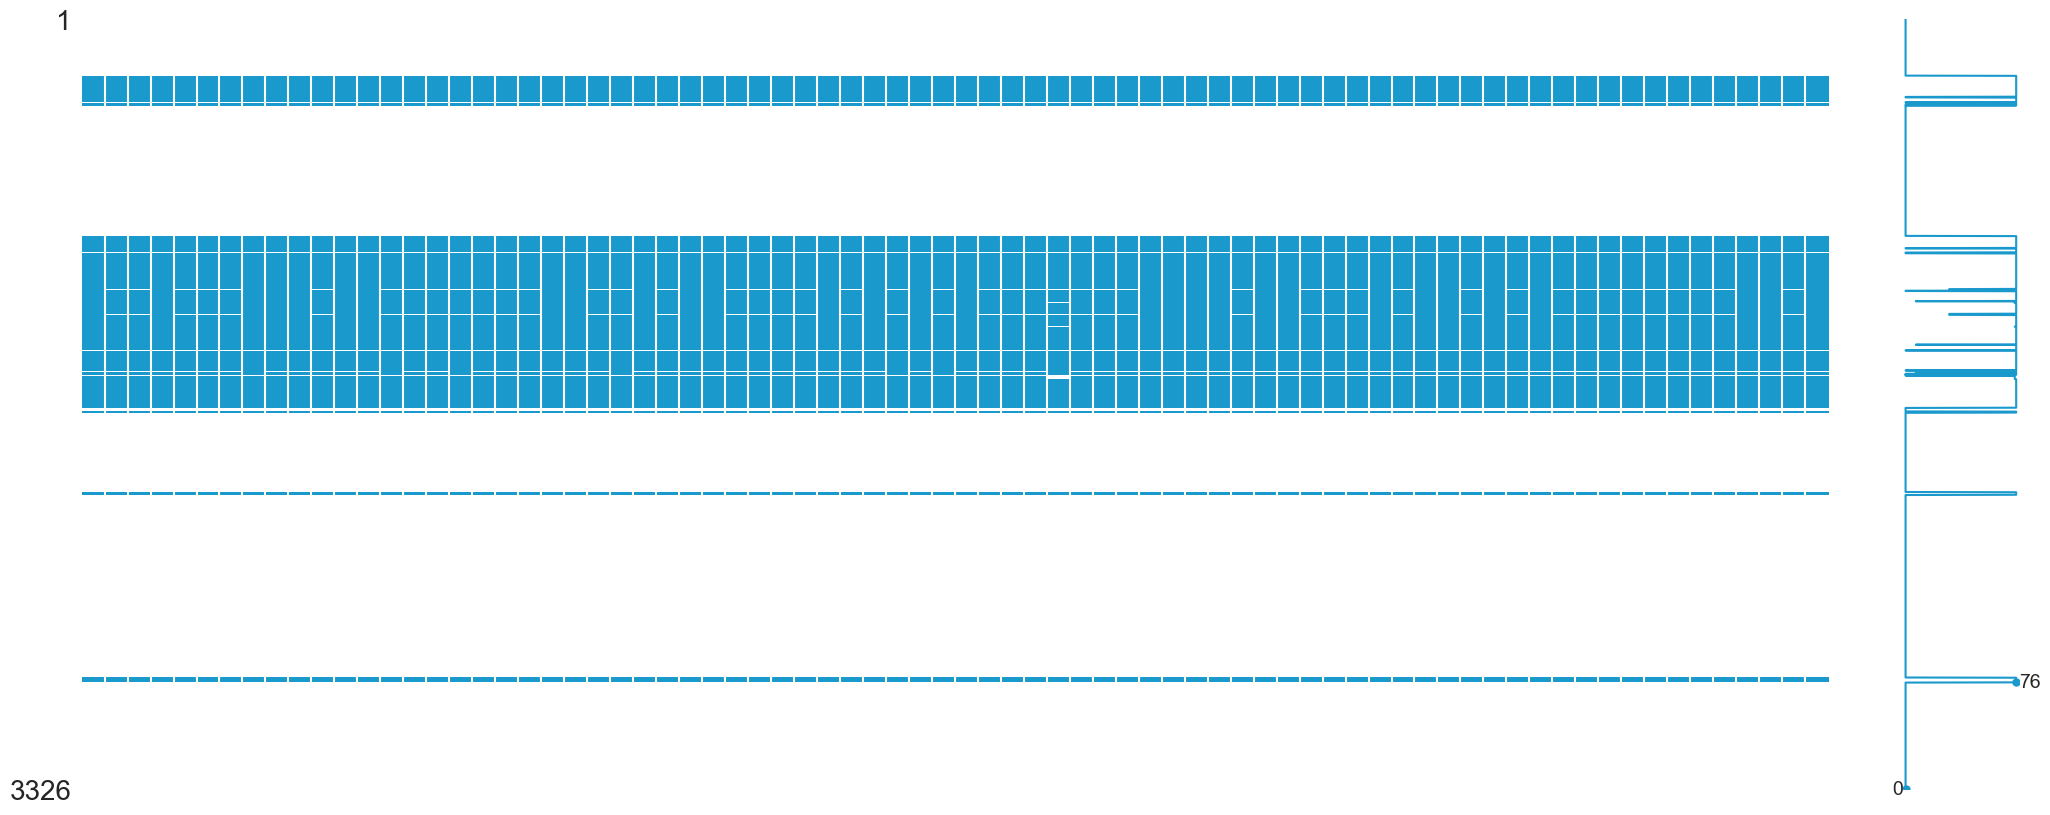

In [76]:
msno.matrix(X_A306.T, color=(0.1, 0.6, 0.8))

<AxesSubplot: >

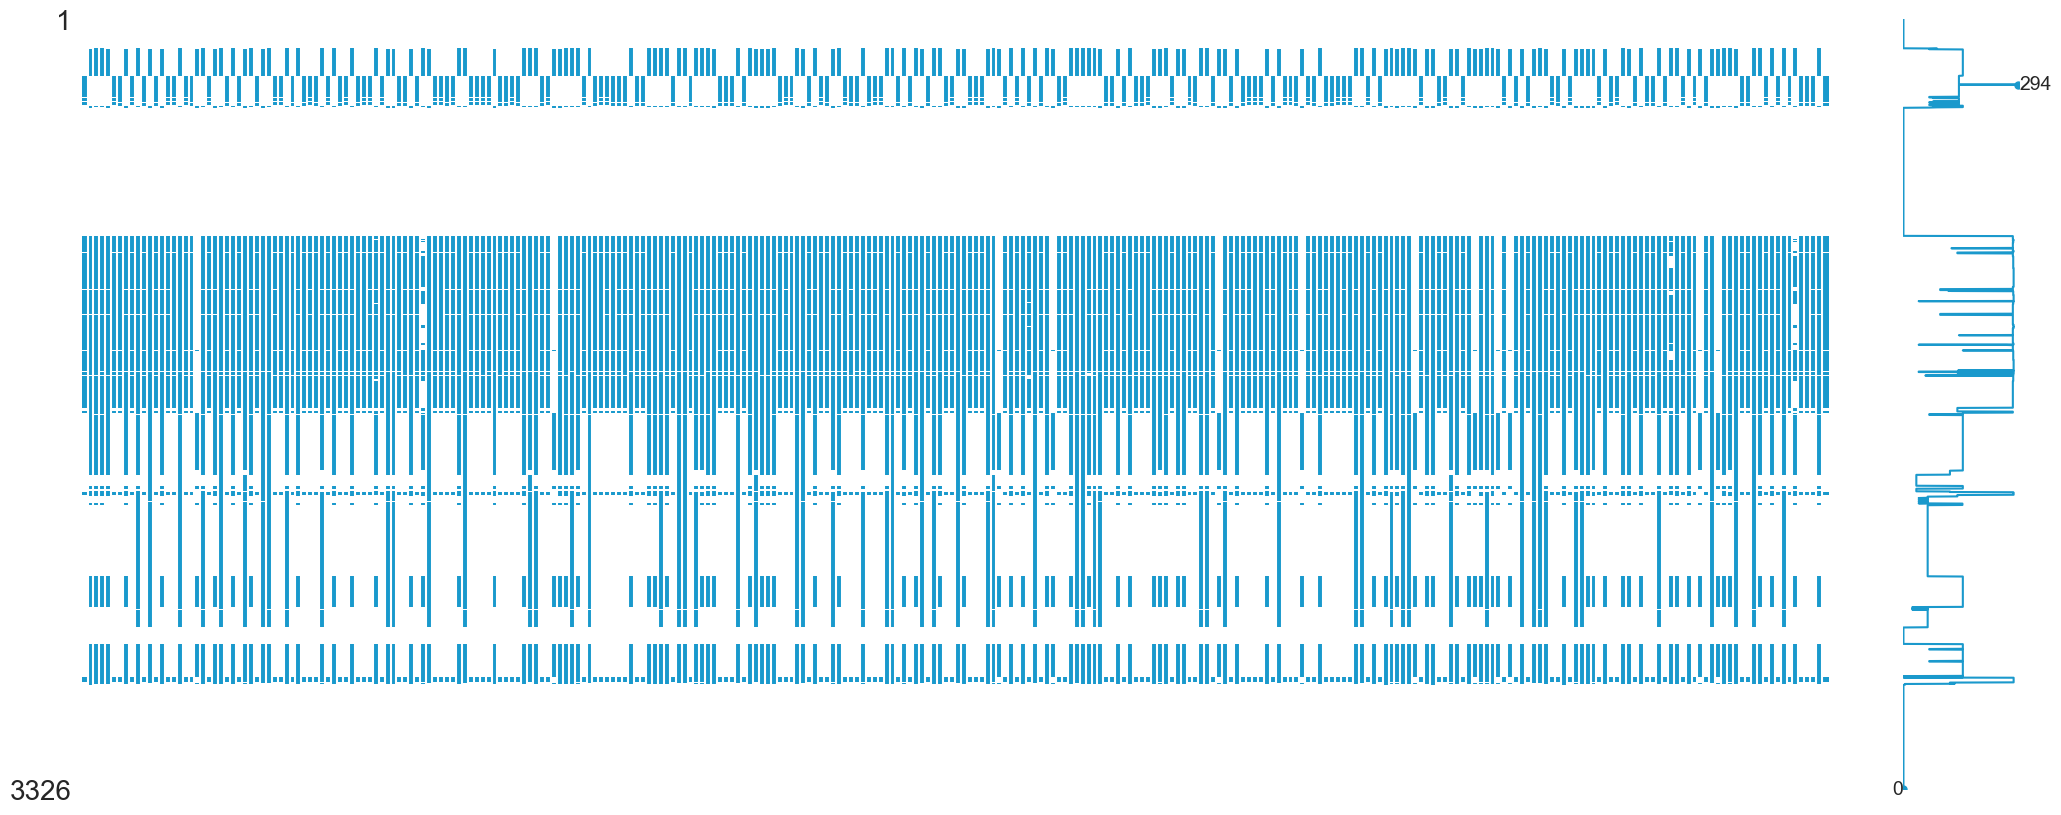

In [77]:
msno.matrix(X_dataA.T, color=(0.1, 0.6, 0.8))

### 결측치 제거

A503 데이터 -> 총 2,236개의 유효하지 않은 X변수가 제거됨

0. 원본 데이터 (838, 3330)
1. 같은 값으로만 채워진 column 제거 (838, 1811)
2. 모든 행이 같은 값을 가지는 중복된 column 제거 (838, 1094)


A103 데이터 -> 총 2,733개의 유효하지 않은 X변수가 제거됨

0. 원본 데이터 (838, 3330)
1. 같은 값으로만 채워진 column 제거 (838, 754)
2. 모든 행이 같은 값을 가지는 중복된 column 제거 (838, 597)682)

In [79]:
# A503 데이터
# 1. Handling missing values 
processed_A503 = A503.copy().fillna(0)
print("0) 원본 데이터 -> ", A503.shape)

# 2. 같은 값으로만 채워진 column 삭제 
value_counts = processed_A503.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))
unique_columns = value_counts[value_counts >= 2].index
duplicated_columns = value_counts[value_counts <= 1].index
processed_A503 = processed_A503.drop(duplicated_columns, axis=1)
print("1) 같은 값으로만 채워진 변수 제거 -> ", processed_A503.shape)

# 3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
df = processed_A503.iloc[:,4:].T.drop_duplicates(keep='first').T
processed_A503 = pd.concat([processed_A503.iloc[:,:4], df], axis=1)
print("2) 모든 행이 같은 값을 가지는 중복된 변수 제거 -> ", processed_A503.shape)

processed_A503

0) 원본 데이터 ->  (152, 3330)
1) 같은 값으로만 채워진 변수 제거 ->  (152, 1811)
2) 모든 행이 같은 값을 가지는 중복된 변수 제거 ->  (152, 1094)


,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_128,X_129,X_130,X_131,X_132,X_133,...,X_2839,X_2840,X_2841,X_2842,X_2843,X_2871,X_2872,X_2873,X_2874,X_2875
0,0,0.522159,T050304,A_31,18031.0,18031.0,0.0,0.0,0.19,0.20,...,5.02,7.02,40.56,0.000156,0.000008,1.0,0.0,0.0,0.0,0.0
1,2,0.541429,T050304,A_31,8164.0,8164.0,0.0,0.0,0.19,0.20,...,5.01,6.53,39.58,0.000120,0.000008,1.0,0.0,0.0,0.0,0.0
2,1,0.529130,T050304,A_31,21863.0,21863.0,0.0,0.0,0.20,0.21,...,4.99,7.04,41.03,0.000174,0.000010,1.0,0.0,0.0,0.0,0.0
3,1,0.528817,T050304,A_31,19078.0,19078.0,0.0,0.0,0.20,0.21,...,4.52,7.01,40.62,0.000398,0.000033,1.0,0.0,0.0,0.0,0.0
4,1,0.526868,T050304,A_31,22322.0,22322.0,0.0,0.0,0.20,0.21,...,5.00,7.00,36.53,0.000187,0.000011,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0,0.521494,T050307,A_31,0.0,0.0,896.0,896.0,0.19,0.21,...,4.50,6.99,40.08,0.001350,0.000012,1.0,0.0,0.0,0.0,0.0
148,2,0.540724,T050307,A_31,0.0,0.0,17860.0,17860.0,0.19,0.20,...,5.01,6.54,39.11,0.001160,0.000018,1.0,0.0,0.0,0.0,0.0
149,2,0.541819,T050307,A_31,0.0,0.0,19854.0,19854.0,0.20,0.21,...,5.00,7.05,36.54,0.001150,0.000009,0.0,0.0,0.0,0.0,0.0
150,2,0.552100,T050307,A_31,0.0,0.0,17771.0,17771.0,0.19,0.20,...,5.04,7.01,38.03,0.001170,0.000006,1.0,0.0,0.0,0.0,0.0


In [80]:
# A103 데이터
# 1. Handling missing values 
processed_A103 = A103.copy().fillna(0)
print("0) 원본 데이터 -> ", A103.shape)

# 2. 같은 값으로만 채워진 column 삭제 
value_counts = processed_A103.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))
unique_columns = value_counts[value_counts >= 2].index
duplicated_columns = value_counts[value_counts <= 1].index
processed_A103 = processed_A103.drop(duplicated_columns, axis=1)
print("1) 같은 값으로만 채워진 변수 제거 -> ", processed_A103.shape)

# 3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
df = processed_A103.iloc[:,4:].T.drop_duplicates(keep='first').T
processed_A103 = pd.concat([processed_A103.iloc[:,:4], df], axis=1)
print("2) 모든 행이 같은 값을 가지는 중복된 변수 제거 -> ", processed_A103.shape)

processed_A103

0) 원본 데이터 ->  (142, 3330)
1) 같은 값으로만 채워진 변수 제거 ->  (142, 754)
2) 모든 행이 같은 값을 가지는 중복된 변수 제거 ->  (142, 597)


,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_246,X_247,X_248,X_250,X_251,X_253,...,X_1696,X_1697,X_2044,X_2045,X_2046,X_2047,X_2048,X_2049,X_2050,X_2051
0,1,0.532754,T010305,A_31,1.0,89.0,0.0,11.0,96.0,11.0,...,37.7,36.2,11570.0,10270.0,10269.0,11568.0,347.0,347.0,347.0,793.0
1,2,0.537122,T010305,A_31,1.0,88.0,0.0,11.0,119.0,11.0,...,36.8,35.3,10402.0,9102.0,9101.0,10401.0,2505.0,2505.0,285.0,2505.0
2,1,0.530303,T010305,A_31,1.0,89.0,0.0,11.0,45.0,11.0,...,37.6,35.2,11401.0,10101.0,10100.0,11400.0,264.0,264.0,264.0,710.0
3,1,0.529171,T010305,A_31,2.0,88.0,0.0,11.0,90.0,11.0,...,37.2,35.3,11550.0,10251.0,10250.0,11549.0,338.0,338.0,338.0,784.0
4,1,0.527910,T010305,A_31,2.0,87.0,0.0,11.0,126.0,11.0,...,35.3,35.2,10422.0,9122.0,9121.0,10420.0,2510.0,2510.0,290.0,2510.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,1,0.534737,T010306,A_31,1.0,95.0,145.0,11.0,0.0,12.0,...,37.2,35.3,10929.0,9629.0,9628.0,10927.0,58.0,58.0,58.0,504.0
138,2,0.548592,T010306,A_31,1.0,89.0,152.0,12.0,0.0,12.0,...,36.2,33.8,10331.0,9031.0,9030.0,10330.0,2472.0,2472.0,252.0,2472.0
139,1,0.526997,T010306,A_31,1.0,91.0,1.0,12.0,0.0,12.0,...,36.8,34.7,10432.0,9132.0,9131.0,10430.0,2513.0,2513.0,293.0,2513.0
140,1,0.530940,T010306,A_31,2.0,96.0,54.0,12.0,0.0,12.0,...,35.3,33.5,11264.0,9965.0,9963.0,11263.0,196.0,196.0,196.0,642.0


### 데이터 시각화

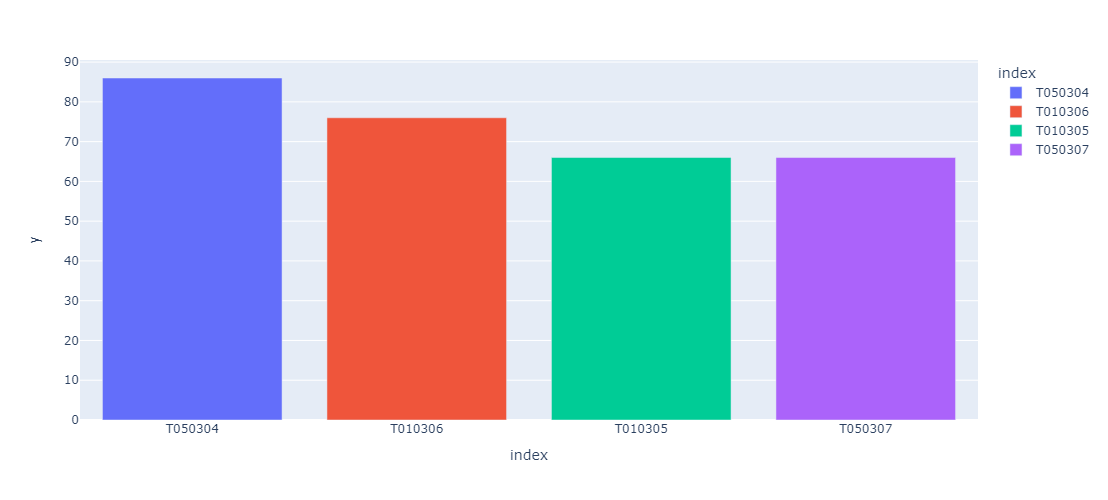

In [81]:
df = dataA.LINE.value_counts()
fig = px.bar(df, x=df.index, y=df.values, color=df.index, width=700, height=500)
fig.show()

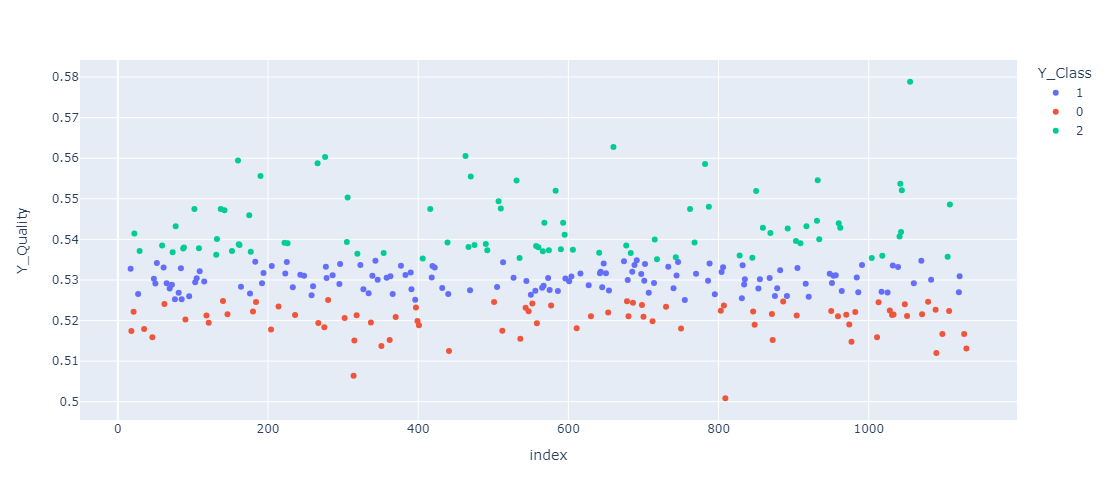

In [82]:
fig = px.scatter(dataA, x=dataA.index, y=dataA.Y_Quality, color=dataA.Y_Class, width=700, height=500)
fig.show()

# 4. Appendix: Dimensionality Reduction

Origianl data, T&O data, A data데이터를 각각 스케일링 전, Robust Scaler, Standard Scaler를 적용한 후  
차원 축소 기법 PCA와 TSNE를 적용하여 시각화한 코드 

- 다양한 경우의 수로 실험해보았으나 유의미한 군집을 만드는 데에 실패하였음
- 그렇기에 차원 축소 기법보다는 다중공선성을 제거하는 방법이나 학습을 통한 features selection이 좀 더 유의미할 것으로 예상됨

## 4.1 Original Data

In [97]:
dataset = []
rs = RobustScaler()
ss = StandardScaler()

# Original data (scaling X)
dataset.append(X_original.fillna(0))

# Scaled data with Robust and Standard scaler 
processed_rs = rs.fit_transform(dataset[0].iloc[:, 4:])
processed_ss = ss.fit_transform(dataset[0].iloc[:, 4:])
dataset.append(processed_rs)
dataset.append(processed_ss)

In [102]:
dataset_2d = []
dataset_3d = []
dataset_tsne = []

for data in dataset:
    pca2 = PCA(n_components=2)
    pca3 = PCA(n_components=3)

    pca2_data = pca2.fit_transform(X_original) 
    pca3_data = pca3.fit_transform(X_original) 
    tsne_data = TSNE(n_components=3).fit_transform(X_original)
    
    pca2_df = pd.DataFrame(pca2_data, columns=['X1', 'X2'])
    pca3_df = pd.DataFrame(pca3_data, columns=['X1', 'X2', 'X3'])  
    tsne_df = pd.DataFrame(tsne_data, columns=['X1', 'X2', 'X3'])  
    
    original_2d = pd.concat([nonX_original, pca2_df], axis=1)
    original_3d = pd.concat([nonX_original, pca3_df], axis=1)
    original_tsne = pd.concat([nonX_original, tsne_df], axis=1)
    
    dataset_2d.append(original_2d)
    dataset_3d.append(original_3d)
    dataset_tsne.append(original_tsne)

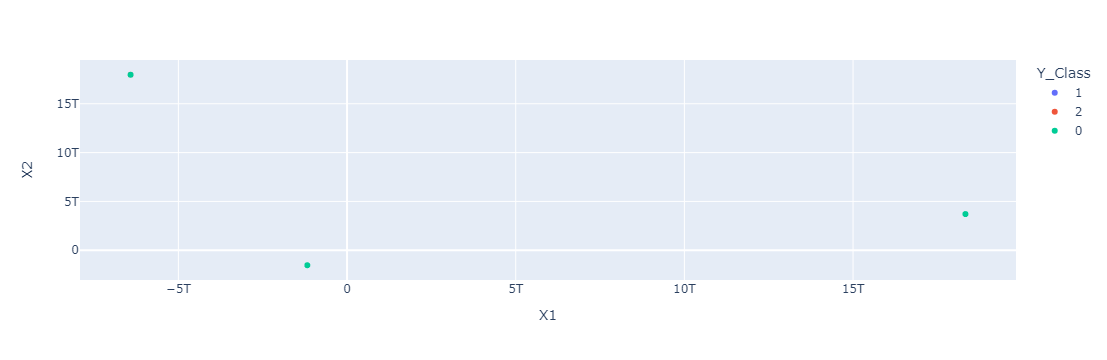

In [118]:
fig = px.scatter(dataset_2d[2], x='X1', y='X2', color='Y_Class')
fig.show()

In [119]:
fig = px.scatter_3d(dataset_3d[2], x='X1', y='X2', z='X3', color='Y_Class')
fig.show()

In [130]:
fig = px.scatter_3d(dataset_tsne[2], x='X1', y='X2', z='X3', color='Y_Class')
fig.show()

## 4.2 T Data

In [124]:
dataset = []
rs = RobustScaler()
ss = StandardScaler()

# Original data (scaling X)
dataset.append(X_dataTO.fillna(0))

# Scaled data with Robust and Standard scaler 
processed_rs = rs.fit_transform(dataset[0].iloc[:, 4:])
processed_ss = ss.fit_transform(dataset[0].iloc[:, 4:])
dataset.append(processed_rs)
dataset.append(processed_ss)

In [126]:
dataset_2d = []
dataset_3d = []
dataset_tsne = []

for data in dataset:
    pca2 = PCA(n_components=2)
    pca3 = PCA(n_components=3)

    pca2_data = pca2.fit_transform(dataset[0]) 
    pca3_data = pca3.fit_transform(dataset[0]) 
    tsne_data = TSNE(n_components=3).fit_transform(dataset[0])
    
    pca2_df = pd.DataFrame(pca2_data, columns=['X1', 'X2'])
    pca3_df = pd.DataFrame(pca3_data, columns=['X1', 'X2', 'X3'])  
    tsne_df = pd.DataFrame(tsne_data, columns=['X1', 'X2', 'X3'])  
    
    dataTO_2d = pd.concat([nonX_dataTO, pca2_df], axis=1)
    dataTO_3d = pd.concat([nonX_dataTO, pca3_df], axis=1)
    dataTO_tsne = pd.concat([nonX_dataTO, tsne_df], axis=1)
    
    dataset_2d.append(dataTO_2d)
    dataset_3d.append(dataTO_3d)
    dataset_tsne.append(dataTO_tsne)

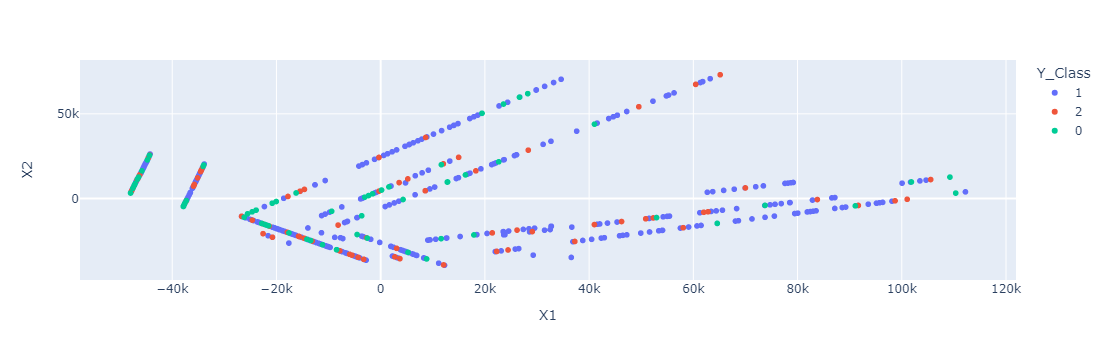

In [127]:
fig = px.scatter(dataset_2d[2], x='X1', y='X2', color='Y_Class')
fig.show()

In [128]:
fig = px.scatter_3d(dataset_3d[2], x='X1', y='X2', z='X3', color='Y_Class')
fig.show()

In [129]:
fig = px.scatter_3d(dataset_tsne[2], x='X1', y='X2', z='X3', color='Y_Class')
fig.show()

## 4.3. A Data

In [132]:
dataset = []
rs = RobustScaler()
ss = StandardScaler()

# Original data (scaling X)
dataset.append(X_dataA.fillna(0))

# Scaled data with Robust and Standard scaler 
processed_rs = rs.fit_transform(dataset[0].iloc[:, 4:])
processed_ss = ss.fit_transform(dataset[0].iloc[:, 4:])
dataset.append(processed_rs)
dataset.append(processed_ss)

In [133]:
dataset_2d = []
dataset_3d = []
dataset_tsne = []

for data in dataset:
    pca2 = PCA(n_components=2)
    pca3 = PCA(n_components=3)

    pca2_data = pca2.fit_transform(dataset[0]) 
    pca3_data = pca3.fit_transform(dataset[0]) 
    tsne_data = TSNE(n_components=3).fit_transform(dataset[0])
    
    pca2_df = pd.DataFrame(pca2_data, columns=['X1', 'X2'])
    pca3_df = pd.DataFrame(pca3_data, columns=['X1', 'X2', 'X3'])  
    tsne_df = pd.DataFrame(tsne_data, columns=['X1', 'X2', 'X3'])  
    
    dataA_2d = pd.concat([nonX_dataA, pca2_df], axis=1)
    dataA_3d = pd.concat([nonX_dataA, pca3_df], axis=1)
    dataA_tsne = pd.concat([nonX_dataA, tsne_df], axis=1)
    
    dataset_2d.append(dataA_2d)
    dataset_3d.append(dataA_3d)
    dataset_tsne.append(dataA_tsne)

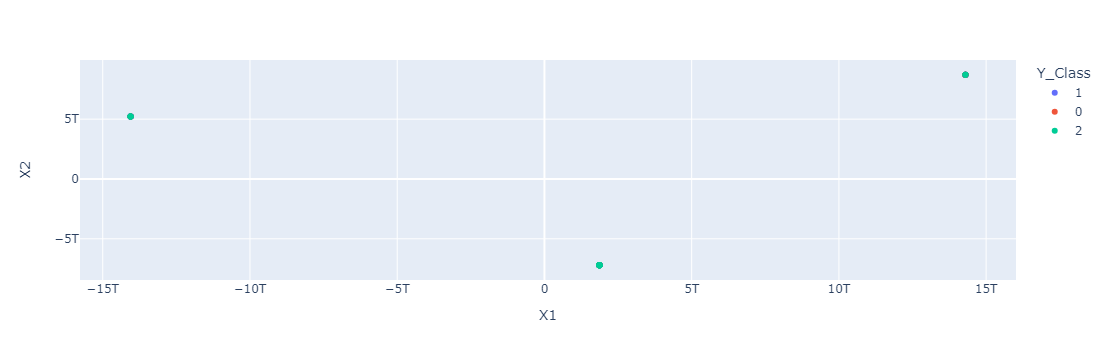

In [134]:
fig = px.scatter(dataset_2d[2], x='X1', y='X2', color='Y_Class')
fig.show()

In [135]:
fig = px.scatter_3d(dataset_3d[2], x='X1', y='X2', z='X3', color='Y_Class')
fig.show()

In [136]:
fig = px.scatter_3d(dataset_tsne[2], x='X1', y='X2', z='X3', color='Y_Class')
fig.show()